# Combine cross-platform benhcmark results on eCLIP and PAR-CLIP data

In [1]:
import os 
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, precision_recall_curve, auc
import pickle
import seaborn as sns
from scipy.stats import wilcoxon

## Get average AUROC values of BMF3, GraphProt, iDeepE, and DeepCLIP (For Figure 4 and supplementary Figure S10 and S11)

In [2]:
eclip_dir = 'plots/eclip/'
pclip_dir = 'plots/parclip/'

datasets = ['BMF cs3','BMF cs4','BMF cs5','GraphProt','iDeepE', 'DeepCLIP']
colors = ['#6baed6','#3182bd','#08519c','#fb9a99','#b2df8a','#fdbf6f']

plotting_dir_combined = 'plots/combined'

### eCLIP

In [3]:
#load cross-validated BMF AUROCS (80/20 split)
metric_by_factor, factors_unique = pickle.load(open(os.path.join('scripts/uniform_vs_nb','metrics_by_factor.pkl'), 'rb' ))
nb_auc = {a:b for a,b in zip(factors_unique, metric_by_factor)}

In [4]:
factor_name, data_matrix, _ = pickle.load(open(os.path.join(eclip_dir,'AUROC_byfactor.pkl'), 'rb' ))

data_pd1 = pd.DataFrame(data = data_matrix, index=factor_name)
data_pd1.columns = datasets

data_pd1['BMF'] = [nb_auc[factor] for factor in data_pd1.index.values]
data_pd1['avg'] = [nb_auc[factor] for factor in data_pd1.index.values]

In [5]:
#Average of four methods
data_pd1.loc[:,[datasets[0],datasets[3],datasets[4],datasets[5]]].mean(axis=1).sort_values(ascending=False)

TARDBP     0.935384
HNRNPL     0.871129
PCBP1      0.857877
KHDRBS1    0.852531
QKI        0.845022
PUM2       0.785135
ZRANB2     0.763853
HNRNPC     0.742579
HNRNPA1    0.704920
CSTF2T     0.677815
IGF2BP1    0.587542
LARP7      0.559175
PUM1       0.453803
CSTF2      0.441362
ZC3H8      0.417115
dtype: float64

### PAR-CLIP

In [6]:
factor_name, data_matrix, _ = pickle.load(open(os.path.join(pclip_dir,'AUROC_byfactor.pkl'), 'rb' ))

data_pd2 = pd.DataFrame(data = data_matrix, index=factor_name)
data_pd2.columns = datasets

data_pd2['BMF'] = [nb_auc[factor] for factor in data_pd2.index.values]

In [7]:
#Average of four methods
data_pd2.loc[:,[datasets[0],datasets[3],datasets[4],datasets[5]]].mean(axis=1).sort_values(ascending=False)

RBPMS      0.912089
QKI        0.868169
ELAVL1     0.861041
ELAVL3     0.779514
ZFP36      0.642961
IGF2BP1    0.622388
CSTF2      0.589706
ELAVL4     0.574616
CSTF2T     0.538864
HNRNPC     0.496432
dtype: float64

## Compare cross-validated and cross-platform AUROCs for BMF cs3 (Figure 3)

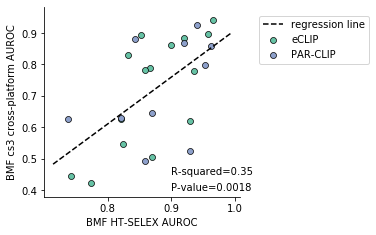

In [8]:
fig, ax = plt.subplots(figsize=(3.5,3.5))
dot_colors = ['#66c2a5','#fc8d62','#8da0cb']
sns.despine()

yaxis_column = 'BMF cs3'
_ = ax.scatter(data_pd1.loc[:,'BMF'].values,data_pd1.loc[:,yaxis_column].values, c=dot_colors[0], linewidths=0.7, edgecolor='black', label='eCLIP')
_ = ax.scatter(data_pd2.loc[:,'BMF'].values,data_pd2.loc[:,yaxis_column].values, c=dot_colors[2], linewidths=0.7, edgecolor='black', label='PAR-CLIP')

x = np.hstack([data_pd1.loc[:,'BMF'].values, data_pd2.loc[:,'BMF'].values])
y = np.hstack([data_pd1.loc[:,yaxis_column].values, data_pd2.loc[:,yaxis_column].values])

m, b = np.polyfit(x, y, 1)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, m*X_plot + b, ls='--', label='regression line', color='black')

import statsmodels.api as sm
results = sm.OLS(y,sm.add_constant(x)).fit()
ax.text(0.9,0.45,f'R-squared={results.rsquared:.2f}')
ax.text(0.9,0.40,f'P-value={results.pvalues[1]:.4f}')

ax.legend(loc=(1.1,0.7))

_ = ax.set_xlabel(f'BMF HT-SELEX AUROC')
_ = ax.set_ylabel(f'{yaxis_column} cross-platform AUROC')
plt.savefig(os.path.join(plotting_dir_combined,f'AUC_BMF_vs_crossplatform_{yaxis_column}.pdf'), bbox_inches='tight')

In [9]:
import statsmodels.api as sm

results = sm.OLS(y,sm.add_constant(x)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     12.49
Date:                Mon, 22 Mar 2021   Prob (F-statistic):            0.00178
Time:                        18:48:49   Log-Likelihood:                 15.218
No. Observations:                  25   AIC:                            -26.44
Df Residuals:                      23   BIC:                            -24.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5850      0.371     -1.577      0.129      -1.353       0.183
x1             1.4937      0.423      3.534      0.002       0.619       2.368
==============================================================================
Omnibus:                        1.385   Durbin-Watson:                   1.652
Prob(Omnibus):                  0.500   Jarque-Bera (JB):                1.219
Skew:                          -0.389   Prob(JB):                        0.544
Kurtosis:                       2.249   Cond. No.                         27.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Combine eCLIP and PAR-CLIP benchmarks
## Figure 3

In [10]:
efactors, eauc, eaucr = pickle.load(open(os.path.join(eclip_dir,'AUROC_byfactor.pkl'), 'rb' ))
eaucr = [np.array(eaucr_i) for eaucr_i in eaucr]

pfactors, pauc, paucr = pickle.load(open(os.path.join(pclip_dir,'AUROC_byfactor.pkl'), 'rb' ))
paucr = [np.array(paucr_i) for paucr_i in paucr]

epfactors = np.concatenate([efactors,pfactors])
epauc = np.concatenate([eauc,pauc])
plotting_dir_combined = 'plots/combined/'

#throw away NAN (only ZC3H8 eCLIP because DeepCLIP failed)
to_keep = ~np.isnan(epauc).any(axis=1)
epauc = np.array([epauc[i] for i in range(len(epauc)) if to_keep[i]])
epfactors = [epfactors[i] for i in range(len(epfactors)) if to_keep[i]]

In [11]:
def plot_comparison_scatter(xaxis=3, yaxis=0):
    
    dot_colors = ['#66c2a5','#8da0cb']
    factor_colors = np.concatenate([np.zeros(efactors.shape[0]-1),np.ones(pfactors.shape[0])])
    factor_colors = [dot_colors[int(i)] for i in factor_colors]
    
    fig, ax = plt.subplots(figsize=(3.5,3.5))
    sns.despine()

    for i in range(epauc.shape[0]):
        if (epauc[i,xaxis]/epauc[i,yaxis])>1.1:
            ax.text(epauc[i,xaxis],epauc[i,yaxis]-0.03,epfactors[i], verticalalignment='top',horizontalalignment='center')
        elif (epauc[i,yaxis]/epauc[i,xaxis])>1.1:
            ax.text(epauc[i,xaxis]-0.03,epauc[i,yaxis],epfactors[i], verticalalignment='center',horizontalalignment='right')

    _ = ax.scatter(epauc[:,xaxis],epauc[:,yaxis], c=factor_colors, linewidths=0.7, edgecolor='black')
    _ = ax.set_xlim(0,1)
    _ = ax.set_ylim(0,1)
    _ = ax.plot([0,1],[0,1],ls='--')
    _ = ax.set_xlabel(f'{datasets[xaxis]} AUROC')
    _ = ax.set_ylabel(f'{datasets[yaxis]} AUROC')
    
    #put wilcoxon p-value
    _ , p = wilcoxon(epauc[:,xaxis],epauc[:,yaxis])
    ax.text(0.5,0.05,f'P-value={p:.4f}')

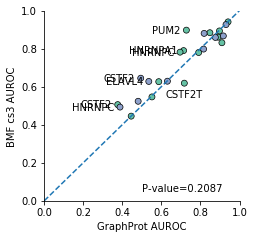

In [12]:
xaxis = 3
yaxis = 0
plot_comparison_scatter(xaxis, yaxis)
plt.savefig(os.path.join(plotting_dir_combined,f'AUC_{xaxis}vs{yaxis}_newbg.pdf'), bbox_inches='tight')

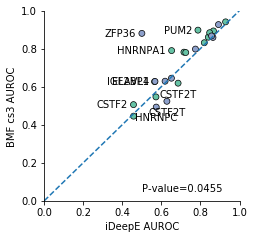

In [13]:
xaxis = 4
yaxis = 0
plot_comparison_scatter(xaxis, yaxis)
plt.savefig(os.path.join(plotting_dir_combined,f'AUC_{xaxis}vs{yaxis}_newbg.pdf'), bbox_inches='tight')

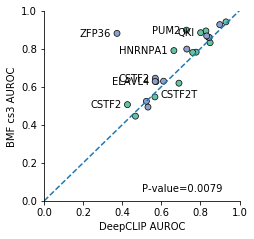

In [14]:
xaxis = 5
yaxis = 0
plot_comparison_scatter(xaxis, yaxis)
plt.savefig(os.path.join(plotting_dir_combined,f'AUC_{xaxis}vs{yaxis}_newbg.pdf'), bbox_inches='tight')

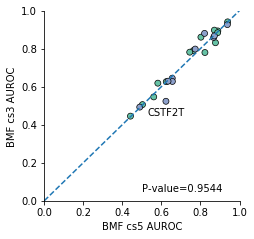

In [15]:
xaxis = 2
yaxis = 0
plot_comparison_scatter(xaxis, yaxis)
plt.savefig(os.path.join(plotting_dir_combined,f'AUC_{xaxis}vs{yaxis}_newbg.pdf'), bbox_inches='tight')

In [16]:
#compare average datasets
def combine_reps_boxplot(metric_arr, thr=0., metric='AUROC'):  
        
    metric_by_factor = pd.DataFrame(metric_arr, columns=datasets)
    
    fig, ax = plt.subplots(figsize=(3.5,3.5))
    
    metric_by_factor_cutoff = metric_by_factor.loc[metric_by_factor.max(axis=1)>thr,:]
    metric_by_factor_cutoff = metric_by_factor_cutoff.reindex(metric_by_factor_cutoff.median().sort_values().index, axis=1)
    
    colors_dict = {a:b for a,b in zip(datasets,colors)}
    new_colors = [colors_dict[col] for col in metric_by_factor_cutoff.columns]
    
    
    bplot = sns.boxplot(x="variable", y="value", data=pd.melt(metric_by_factor_cutoff), ax=ax, 
                        width=0.6,)
    for i in range(len(new_colors)):
        mybox = bplot.artists[i]
        mybox.set_facecolor(new_colors[i])
        mybox.set_edgecolor('black')
    
    sns.swarmplot(x="variable", y="value", data=pd.melt(metric_by_factor_cutoff), color='black', ax=ax, size=4)
    sns.despine()
    
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    
    ax.set_title(f'AUROC by factor, AUROC threshold = {thr:.2f}')
    ax.set_xlabel('')
    ax.set_ylabel(metric)
    ax.set_ylim(0,1)
    ax.plot(ax.get_xlim(),[0.5,0.5],'--')
    plt.xticks(rotation=45, ha='right')

    plt.savefig(os.path.join(plotting_dir_combined,f'{metric}_boxplot_thr{thr:.1f}_newbg.pdf'), bbox_inches='tight')

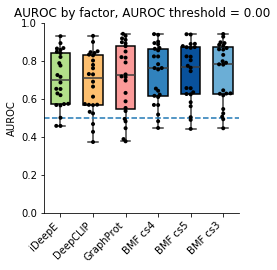

In [17]:
combine_reps_boxplot(epauc, thr=0)

## Compare average precision (Figure S7)

In [18]:
efactors, eauc, eaucr = pickle.load(open(os.path.join(eclip_dir,'AP_byfactor.pkl'), 'rb' ))
eaucr = [np.array(eaucr_i) for eaucr_i in eaucr]

pfactors, pauc, paucr = pickle.load(open(os.path.join(pclip_dir,'AP_byfactor.pkl'), 'rb' ))
paucr = [np.array(paucr_i) for paucr_i in paucr]

epfactors = np.concatenate([efactors,pfactors])
epauc = np.concatenate([eauc,pauc])
plotting_dir_combined = 'plots/combined/'

#throw away NAN (only HNRNPC because iDEEP failed)
to_keep = ~np.isnan(epauc).any(axis=1)
epauc = np.array([epauc[i] for i in range(len(epauc)) if to_keep[i]])
epfactors = [epfactors[i] for i in range(len(epfactors)) if to_keep[i]]

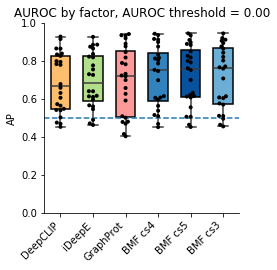

In [19]:
combine_reps_boxplot(epauc, thr=0, metric='AP')

## Relationship between k and performance of BMF (Figure S8)

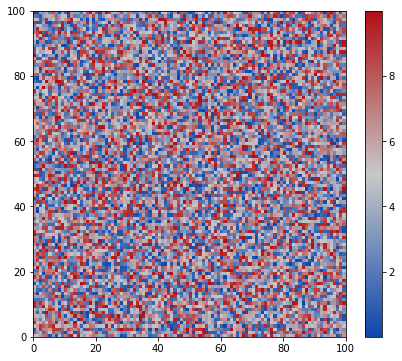

In [32]:
# MAKE CUSTOM COLORMAP
data = np.random.random([100, 100]) * 10

N = 256
grey_value = 200
red = np.ones((N, 4))
#red:178,24,43
#grey:150,150,150
red[:, 0] = np.linspace(178/N, grey_value/N, N) # R = 255
red[:, 1] = np.linspace(15/N, grey_value/N, N) # G = 232
red[:, 2] = np.linspace(20/N, grey_value/N, N)  # B = 11
red_cmap = ListedColormap(red)

blue = np.ones((N, 4))
#blue:33,102,172
#grey:150,150,150
blue[:, 0] = np.linspace(13/N, grey_value/N, N) # R = 255
blue[:, 1] = np.linspace(70/N, grey_value/N, N) # G = 232
blue[:, 2] = np.linspace(172/N, grey_value/N, N)  # B = 11
blue_cmap = ListedColormap(blue)

newcolors2 = np.vstack((blue_cmap(np.linspace(0, 1, 128)),
                       red_cmap(np.linspace(1, 0, 128))))
custom_colormap = ListedColormap(newcolors2, name='double')
plt.figure(figsize=(7, 6))
plt.pcolormesh(data, cmap=custom_colormap)
plt.colorbar()

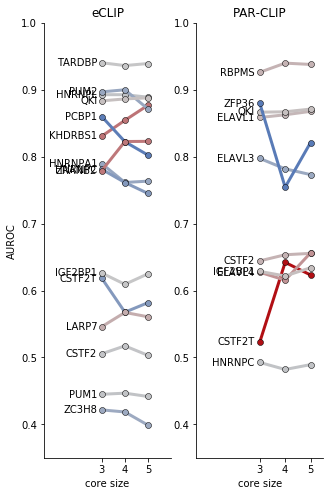

In [33]:
sns.axes_style("white")
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(5,8))
xpos = np.arange(3,6)
#sns.despine(fig=fig,trim=True)

colorsList = ['#b2182b','#bdbdbd', '#2166ac']
cmap = custom_colormap
a = epauc[:,2]-epauc[:,0]
max_range = max(abs(min(a)),abs(max(a)))
a = (a+max_range)/(2*max_range)
colors = [cmap(c) for c in a]

#cmap = matplotlib.cm.get_cmap('coolwarm')
#colors = epauc[:,2]-epauc[:,0]
#colors = (colors-min(colors)+0.015)/(max(colors)-min(colors))
#colors = [cmap(c) for c in colors]

for i, factor in enumerate(epfactors[:len(efactors)]):
    ax1.plot(xpos,epauc[i,0:3], 'o-', color=colors[i],lw=3,
            markeredgecolor='black',markeredgewidth=0.5)
    ax1.text(2.8,epauc[i,0], epfactors[i], horizontalalignment='right', 
             fontsize=10,
             verticalalignment='center')

ax1.set_xlim(.5,6)
ax1.set_ylim(0.35,1)
ax1.set_title('eCLIP')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticks(xpos)
ax1.set_xlabel('core size')
ax1.set_ylabel('AUROC')

for i, factor in enumerate(epfactors[len(efactors):]):
    ax2.plot(xpos,epauc[i+len(efactors),0:3], 'o-', color=colors[i+len(efactors)],lw=3,
            markeredgecolor='black',markeredgewidth=0.5)
    ax2.text(2.8,epauc[i+len(efactors),0], epfactors[i+len(efactors)], 
             fontsize=10,
             horizontalalignment='right', 
             verticalalignment='center')

ax2.set_xlim(.5,5.5)
ax2.set_ylim(0.35,1)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_xticks(xpos)
ax2.set_title('PAR-CLIP')
ax2.set_xlabel('core size')
plt.savefig(os.path.join(plotting_dir_combined,f'AUROC_vs_CS_custom_colormap.pdf'), bbox_inches='tight')